# Mr.HelpMate AI
## Problem statement
The goal of the project will be to build a robust generative search system capable of effectively and accurately answering questions from a policy document. 

[Group Member Life Insurance Policy](Principal-Sample-Life-Insurance-Policy.pdf)

The project should implement all the three layers effectively. It will be key to try out various strategies and experiments in various layers in order to build an effective search system. Let's explore what you need to do in each of the layers, and the possible experimentations that you can perform based on various choices.

- **The Embedding Layer:** The PDF document needs to be effectively processed, cleaned, and chunked for the embeddings. Here, the choice of the chunking strategy will have a large impact on the final quality of the retrieved results. So, make sure that you try out various stratgies and compare their performances.
Another important aspect in the embedding layer is the choice of the embedding model. You can choose to embed your chunks using the OpenAI embedding model or any model from the SentenceTransformers library on HuggingFace.
- **The Search Layer:** Here, you first need to design at least 3 queries against which you will test your system. You need to understand and skim through the document, and accordingly come up with some queries, the answers to which can be found in the policy document.
Next, you need to embed the queries and search your ChromaDB vector database against each of these queries. Implementing a cache mechanism is also mandatory.
Finally, you need to implement the re-ranking block, and for this you can choose from a range of cross-encoding models on HuggingFace. 
- **The Generation Layer:** In the generation layer, the final prompt that you design is the major component. Make sure that the prompt is exhaustive in its instructions, and the relevant information is correctly passed to the prompt. You may also choose to provide some few-shot examples in an attempt to improve the LLM output.
Make sure you try out different strategies and models in each layer, and you might be surprised with the variety of top answers retrieved and generated by your system. 

**Note:** You need to test your system with at least 3 self-designed queries that can help you gauge the quality of outputs delivered by your system. Also, as a check, you need to submit the screenshots of the outputs along with the code and documentation. The details of the screenshots that you need to share are provided below.

- **Top 3 Results from the Search Layer:** You need to share 3 screenshots against 3 self-designed queries that clearly showcase the top 3 results/chunks retrieved from the search layer. Please share 1 screenshot for each query and its output.
- **Final Generated Answer from the Generation Layer:** Here, you are required to share 3 screenshots of the same 3 queries with the final output generated by the LLM in the generation layer. Please share one screenshot for each query and its output.

So, overall, you will need to share 6 screenshots.

### Importing libraries

In [1]:
import pdfplumber
from operator import itemgetter
import json
from pathlib import Path
import pandas as pd

In [2]:
from IPython.display import Markdown, display
import time

# Rag Components
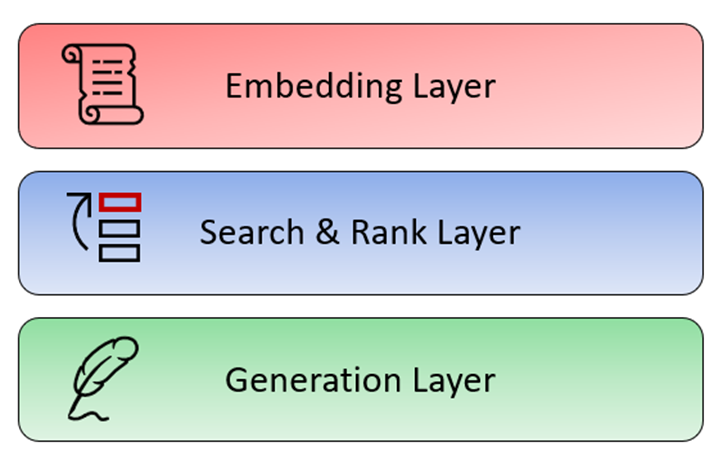

<br/>
<br/>
<br/>

# RAG architecture
This will be a three step process.
#### Step 1: **Text Processing with Embedding model and storing to Vector store**
<img src="Step1.png"/>

<br/>
<br/>
<br/>

#### Step 2: **Query Embedding and searching in Vector cache and Vector store**
<img src="Step2.png"/>

### The Results are selected after reranking using the **cross encoder ranking**

<img src="cross_encoder.png"/>

<br/>
<br/>
<br/>

#### Step 3: **Generate Search layer - Generate response from LLM based on query prompt and search results**
<img src="Step3.png"/>

# Step 1: **Text Processing with Embedding model and storing to Vector store**
<img src="Step1.png"/>

## **Embedding Layer**
- Processing the Text

In [3]:
pdf_path = "dataset"
sample_pdf = "Principal-Sample-Life-Insurance-Policy.pdf"

In [4]:
def preprocess_pdf(pdf_path):
    pages = 0
    tables = []
    text_length = []
    char_length = []
    with pdfplumber.open(pdf_path) as pdf:
        pages = len(pdf.pages)
        for page in pdf.pages:
            if len(page.extract_tables()) > 0:
                tables.append(page.extract_tables())
            text_length.append(len(page.extract_text().split(" ")))
            char_length.append([len(word) for word in page.extract_text().split(" ")])

        char_length = [sum(char, 0) for char in char_length]
    print(f"""
    Total Pages:                 {pages}
    Total Tables:                {len(tables)}
    Total Words:                 {sum(text_length, 0)}
    Max Words in a Page:         {max(text_length)}
    Total Charachters:           {sum(char_length, 0)}
    Max Charachters in a Page:   {max(char_length)}
    """)

In [5]:
preprocess_pdf(f"{pdf_path}/{sample_pdf}")


    Total Pages:                 64
    Total Tables:                0
    Total Words:                 15311
    Max Words in a Page:         425
    Total Charachters:           84231
    Max Charachters in a Page:   2277
    


#### Observation
- Total number of pages are `64`
- There are no tables found
- Total words in the PDF is `15311`
- Maximum word in a page is `425`
- Total charchters `84231`
- Maximum charachters in a page `2277`
<br/>
<br/>

#### Do we need table processing?
- Table processing is not needed as it does not have any table
- We can use any model that supports tokens within the limit of page level charachters/ words

### PDF processing
- Extract text
- Extract tables (if any)
- Generate a dataframe from the PDF

In [6]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [7]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []

    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

In [8]:
def generate_data_from_pdf(pdf_path):
    # Define the directory containing the PDF files
    pdf_directory = Path(pdf_path)
    
    # Initialize an empty list to store the extracted texts and document names
    data = []

    print(f"{len(list(pdf_directory.glob('*.pdf')))} PDF file(s) to parse")
    # Loop through all files in the directory
    for pdf_path in pdf_directory.glob("*.pdf"):
    
        # Process the PDF file
        print(f"...Processing {pdf_path.name}")
    
        # Call the function to extract the text from the PDF
        extracted_text = extract_text_from_pdf(pdf_path)
    
        # Convert the extracted list to a PDF, and add a column to store document names
        extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
        extracted_text_df['Document Name'] = pdf_path.name
    
        # Append the extracted text and document name to the list
        data.append(extracted_text_df)
    
        # Print a message to indicate progress
        print(f"Finished processing {pdf_path.name}")
    
    # Print a message to indicate all PDFs have been processed
    print("All PDFs have been processed.")

    return data

In [9]:
pdfs_data = generate_data_from_pdf(pdf_path=pdf_path)

1 PDF file(s) to parse
...Processing Principal-Sample-Life-Insurance-Policy.pdf
Finished processing Principal-Sample-Life-Insurance-Policy.pdf
All PDFs have been processed.


In [10]:
pdfs_data

[   Page No.                                          Page_Text  \
 0    Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...   
 1    Page 2                 This page left blank intentionally   
 2    Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   
 3    Page 4                 This page left blank intentionally   
 4    Page 5  PRINCIPAL LIFE INSURANCE COMPANY (called The P...   
 ..      ...                                                ...   
 59  Page 60  I f a Dependent who was insured dies during th...   
 60  Page 61  Section D - Claim Procedures Article 1 - Notic...   
 61  Page 62  A claimant may request an appeal of a claim de...   
 62  Page 63                 This page left blank intentionally   
 63  Page 64  Principal Life Insurance Company Des Moines, I...   
 
                                  Document Name  
 0   Principal-Sample-Life-Insurance-Policy.pdf  
 1   Principal-Sample-Life-Insurance-Policy.pdf  
 2   Principal-Sample-Life-Insurance-Policy.

In [11]:
pdf_dataframe = pd.concat(pdfs_data, ignore_index=True)
pdf_dataframe

,Page No.,Page_Text,Document Name
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf
...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,Principal-Sample-Life-Insurance-Policy.pdf
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,Principal-Sample-Life-Insurance-Policy.pdf
61,Page 62,A claimant may request an appeal of a claim de...,Principal-Sample-Life-Insurance-Policy.pdf
62,Page 63,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf


### Add Text Length field in the dataframe
- Add a new field `Text Length`
- Remove the rows with word count <= 10
- Create the dataframe

In [12]:
pdf_dataframe["Text Length"] = pdf_dataframe.Page_Text.apply(lambda x: len(x.split(" ")))
pdf_dataframe = pdf_dataframe[pdf_dataframe["Text Length"] > 10]
print(pdf_dataframe.shape)
pdf_dataframe = pdf_dataframe.reset_index(drop=True)
pdf_dataframe

(60, 4)


,Page No.,Page_Text,Document Name,Text Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
1,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230
2,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110
3,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153
4,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176
5,Page 8,Section A - Member Life Insurance Schedule of ...,Principal-Sample-Life-Insurance-Policy.pdf,171
6,Page 9,P ART I - DEFINITIONS When used in this Group ...,Principal-Sample-Life-Insurance-Policy.pdf,387
7,Page 10,T he legally recognized union of two eligible ...,Principal-Sample-Life-Insurance-Policy.pdf,251
8,Page 11,(2) has been placed with the Member or spouse ...,Principal-Sample-Life-Insurance-Policy.pdf,299
9,Page 12,An institution that is licensed as a Hospital ...,Principal-Sample-Life-Insurance-Policy.pdf,352


## Chunking
- Single page chunking with fixed length and overlap in the same page
- Generally Insurance PDFs does not spill context over pages so we are not overlapping the chunking across pages
- Return the dataframe with `DocumentName`, `Page_Text`, and `PageNo.`


In [13]:
def chunk_text(row):
    word_limit = 250
    sample_text = row["Page_Text"].split(".")
    
    new_sample_text = []
    previous_text = ""

    pages = []
    
    for text in sample_text:
        if len(text) < 3:
            if previous_text == "":
                previous_text = text
            else:
                previous_text = previous_text + " " + text
            continue
        else:
            new_sample_text.append(previous_text + " " + text)
            previous_text = ""
    
    sentence_list = []
    new_sentence = ""
    current_count = 0
    for index, text in enumerate(new_sample_text):
        if current_count + len(text.split(" ")) < word_limit:
            if new_sentence == "":
                new_sentence = text
            else:
                new_sentence += ". " + text
        else:
            sentence_list.append(new_sentence.strip())
            new_sentence = (".".join(new_sentence.split(".")[-2:]) + ". " + text).strip()
            current_count = len(new_sentence.split(' '))
            continue
                                
        current_count += len(text.split(" "))
    
    
    sentence_list.append(new_sentence.strip())

    page_data = [{"Page No." : row["Page No."], "Page_Text" : sentence, "Document Name": row["Document Name"]} for sentence in sentence_list]
    
    return page_data

In [14]:
def generate_document():
    data = []
    for index in range(0, pdf_dataframe.shape[0]):
        result = chunk_text((pdf_dataframe.iloc[index])[["Page No.", "Page_Text", "Document Name"]])
        data.append(result)

    return data

In [15]:
pdf_dataframe = pd.DataFrame([element for innerList in generate_document() for element in innerList])

### Add `text length` field in the dataframe

In [16]:
pdf_dataframe["Text Length"] = pdf_dataframe.Page_Text.apply(lambda x: len(x.split(" ")))
display(pdf_dataframe)

,Page No.,Page_Text,Document Name,Text Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
1,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,244
2,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,116
3,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153
4,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176
...,...,...,...,...
108,Page 60,Article 3 - Beneficiary A Member may name or l...,Principal-Sample-Life-Insurance-Policy.pdf,97
109,Page 61,Section D - Claim Procedures Article 1 - Notic...,Principal-Sample-Life-Insurance-Policy.pdf,246
110,Page 61,The Principal may request additional informati...,Principal-Sample-Life-Insurance-Policy.pdf,246
111,Page 62,A claimant may request an appeal of a claim de...,Principal-Sample-Life-Insurance-Policy.pdf,239


In [17]:
max(pdf_dataframe["Text Length"])

283

In [18]:
pdf_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Page No.       113 non-null    object
 1   Page_Text      113 non-null    object
 2   Document Name  113 non-null    object
 3   Text Length    113 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 3.7+ KB


### Adding Metadata to the PDF 
- Metadata is the combnation of `PageNo` and `DocumentName`

In [19]:
pdf_dataframe["Metadata"] = pdf_dataframe.apply(lambda x: {"Page No.": x["Page No."], "Document Name" : x["Document Name"][:-4]}, axis=1)
pdf_dataframe

,Page No.,Page_Text,Document Name,Text Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30,"{'Page No.': 'Page 1', 'Document Name': 'Princ..."
1,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,244,"{'Page No.': 'Page 3', 'Document Name': 'Princ..."
2,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,116,"{'Page No.': 'Page 5', 'Document Name': 'Princ..."
3,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153,"{'Page No.': 'Page 6', 'Document Name': 'Princ..."
4,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176,"{'Page No.': 'Page 7', 'Document Name': 'Princ..."
...,...,...,...,...,...
108,Page 60,Article 3 - Beneficiary A Member may name or l...,Principal-Sample-Life-Insurance-Policy.pdf,97,"{'Page No.': 'Page 60', 'Document Name': 'Prin..."
109,Page 61,Section D - Claim Procedures Article 1 - Notic...,Principal-Sample-Life-Insurance-Policy.pdf,246,"{'Page No.': 'Page 61', 'Document Name': 'Prin..."
110,Page 61,The Principal may request additional informati...,Principal-Sample-Life-Insurance-Policy.pdf,246,"{'Page No.': 'Page 61', 'Document Name': 'Prin..."
111,Page 62,A claimant may request an appeal of a claim de...,Principal-Sample-Life-Insurance-Policy.pdf,239,"{'Page No.': 'Page 62', 'Document Name': 'Prin..."


## Embedding with Gemini and ChromaDB store

In [20]:
gemini_key = open("API/gemini_key", "r").read()

#### Import the Required Libraries

In [21]:
import google.generativeai as genai
genai.configure(api_key=gemini_key)

import chromadb
from chromadb import Documents, EmbeddingFunction, Embeddings
client_db = chromadb.PersistentClient()

### Gemini Model to return the encoding
- For encoding, using the `models/text-embedding-004`

In [22]:
class GeminiEmbeddingFunction(EmbeddingFunction):
    def __call__(self, input: Documents) -> Embeddings:
        model="models/text-embedding-004"
        title = "Custom query"
        return genai.embed_content(model=model, content=input, task_type="retrieval_document", title=title)["embedding"]

In [23]:
gemini_collection = "Gemini_RAG_on_Insurance"
gemini_collection_cache = "Gemini_RAG_on_Insurance_cache"

### Store the document with Embedding in the Vector Store
- Ids will be the indexing of the chunk in the list
- store will save metadata, id and documents (in encoded format)

In [24]:
def gemini_insertToDBPipeline(insurance_pdfs_data):
    embeddings = []

    documents_list = insurance_pdfs_data['Page_Text'].tolist()
    metadata_list = insurance_pdfs_data['Metadata'].tolist()

    try:
        coll = client_db.get_collection(name=gemini_collection)
        client_db.delete_collection(name=gemini_collection)
        insurance_collection = client_db.get_or_create_collection(name=gemini_collection, embedding_function=GeminiEmbeddingFunction())
    except:
        insurance_collection = client_db.get_or_create_collection(name=gemini_collection, embedding_function=GeminiEmbeddingFunction())
    
    
    insurance_collection.add(
        documents=documents_list,
        ids=[str(i) for i in range(0, len(documents_list))],
        metadatas = metadata_list
    )
    
    return insurance_collection

In [25]:
gemini_insurance_collection = gemini_insertToDBPipeline(insurance_pdfs_data=pdf_dataframe)

In [26]:
gemini_insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': [[0.05808296054601669,
   0.01626746729016304,
   0.017107166349887848,
   -0.011411067098379135,
   -0.019611956551671028,
   0.013185777701437473,
   0.012549198232591152,
   0.04929949715733528,
   0.03484632074832916,
   0.04377219080924988,
   -0.009162954986095428,
   0.027559656649827957,
   0.025312934070825577,
   0.00272087543271482,
   -0.028180420398712158,
   -0.024827292189002037,
   -0.06434060633182526,
   -0.011103021912276745,
   -0.025857390835881233,
   -0.02561776153743267,
   -0.0044266534969210625,
   0.01705886982381344,
   0.02157258242368698,
   -0.02565539814531803,
   0.04824254661798477,
   -0.0323699451982975,
   -0.02484562061727047,
   -0.06569481641054153,
   -0.02160930261015892,
   -0.11299003660678864,
   0.007263218984007835,
   0.02685205638408661,
   -0.020195672288537025,
   -0.010034088045358658,
   0.006010481156408787,
   0.01802326738834381,
   -0.03495195508003235,
   -0.023728132247924805,
   0.024389

# Step 2: **Query Embedding and searching in Vector cache and Vector store**
<img src="Step2.png"/>

### Cache the collection for already queried request response
- Quality of the search results
- Implementation of cache
- Selection and implementation of a re-ranker

In [27]:
def gemini_create_cache_collection():
    try:
        coll = client_db.get_collection(name=gemini_collection_cache)
        client_db.delete_collection(name=gemini_collection_cache)
        insurance_collection_cache = client_db.get_or_create_collection(name=gemini_collection_cache, embedding_function=GeminiEmbeddingFunction())
    except:
        insurance_collection_cache = client_db.get_or_create_collection(name=gemini_collection_cache, embedding_function=GeminiEmbeddingFunction())

    return insurance_collection_cache

In [28]:
gemini_insurance_collection_cache = gemini_create_cache_collection()

### Semantic search in vector Database
- Take the query and check if a similar query is already present in cache
- we are using `distance` threshold 0.2 to maintain accuracy
- If the query is present then extract it from the cache and return the results
- If it is not present in cache then search in the actual database
- Store the results in Cache db along with the query
- Return the results

In [29]:
def get_results_gemini(query):
    threshold = 0.2
    
    cache_result = gemini_insurance_collection_cache.query(
                        query_texts = query,
                        n_results = 1
                    )

    if cache_result["distances"][0] == [] or cache_result["distances"][0][0] > threshold:
        query_result = gemini_insurance_collection.query(
                            query_texts=query,
                            n_results=10
                        )
        Keys = []
        Values = []
        for key, val in query_result.items():
            if val is None:
                continue
            for i in range(10):
                try:
                    Keys.append(str(key) + str(i))
                    Values.append(str(val[0][i]))
                except:
                    continue
    
        gemini_insurance_collection_cache.add(
            documents=[query],
            ids=[query],
            metadatas=dict(zip(Keys, Values))
        )
        # print("Result is not found in cache")
        result_dict = {
            "Metadatas" : query_result["metadatas"][0], 
            "Documents": query_result["documents"][0],
            "Distances": query_result["distances"][0],
            "IDs":query_result["ids"][0]
        }
        result_df = pd.DataFrame.from_dict(result_dict)
        return result_df
    elif cache_result['distances'][0][0] <= threshold:
        cache_result_dict = cache_result['metadatas'][0][0]
        ids = []
        documents = []
        distances = []
        metadatas = []

        for key, value in cache_result_dict.items():
            if "ids" in key:
                ids.append(value)
            elif "documents" in key:
                documents.append(value)
            elif "distances" in key:
                distances.append(value)
            elif "metadatas" in key:
                metadatas.append(value)

        # print("Results found in cache")
        # Create a DataFrame
        result_df = pd.DataFrame({
            'IDs': ids,
            'Documents': documents,
            'Distances': distances,
            'Metadatas': metadatas
        })

        return result_df
    return None

In [30]:
sample_query = "What are the death benefits?"
gemini_results_df = get_results_gemini(query=sample_query)

In [31]:
gemini_results_df

,Metadatas,Documents,Distances,IDs
0,{'Document Name': 'Principal-Sample-Life-Insur...,c If a beneficiary dies at the same time or ...,0.482633,83
1,{'Document Name': 'Principal-Sample-Life-Insur...,PART IV - BENEFITS Section A - Member Life Ins...,0.512368,79
2,{'Document Name': 'Principal-Sample-Life-Insur...,Section C - Dependent Life Insurance Article 1...,0.529088,105
3,{'Document Name': 'Principal-Sample-Life-Insur...,If the approved amount of insurance is differe...,0.530421,80
4,{'Document Name': 'Principal-Sample-Life-Insur...,Section A - Member Life Insurance Schedule of ...,0.532284,5
5,{'Document Name': 'Principal-Sample-Life-Insur...,I f a Dependent who was insured dies during th...,0.544227,107
6,{'Document Name': 'Principal-Sample-Life-Insur...,(1) only one Accelerated Benefit payment will ...,0.553739,93
7,{'Document Name': 'Principal-Sample-Life-Insur...,If a Member elects a Dependent Life benefit in...,0.556363,106
8,{'Document Name': 'Principal-Sample-Life-Insur...,"(3) above, the maximum amount will be the Cove...",0.556549,73
9,{'Document Name': 'Principal-Sample-Life-Insur...,d Effective Dates and Premium Waiver Coverage...,0.558079,89


### Reranking the search results using the `CrossEncoder`
- Use the `CrossEncoder` from `sentence_transformers`
- Rank the results based on cross encoder rankings
- High rank is better than the low rank in CrossEncoder
- Cross Encoder takes the array of `Query` and `Response` and then compares the results and rank them as per relation to the query


### The Results are selected after reranking using the **cross encoder ranking**
<img src="cross_encoder.png"/>

In [32]:
from sentence_transformers import CrossEncoder, util

In [33]:
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

/Users/mohit.dubey/anaconda3/envs/miniforge/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Use CrossEncoder to rerank the output from semantic search
- Using `cross-encoder/ms-marco-MiniLM-L-6-v2` to rank

In [34]:
def cross_encoding(results_df):
    cross_inputs = [[sample_query, response] for response in results_df['Documents']]
    cross_rerank_scores = cross_encoder.predict(cross_inputs)
    return cross_rerank_scores

In [35]:
gemini_cross_rerank_scores = cross_encoding(gemini_results_df)

In [36]:
gemini_results_df['Reranked_scores'] = gemini_cross_rerank_scores

In [37]:
gemini_results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,{'Document Name': 'Principal-Sample-Life-Insur...,c If a beneficiary dies at the same time or ...,0.482633,83,-7.065477
1,{'Document Name': 'Principal-Sample-Life-Insur...,PART IV - BENEFITS Section A - Member Life Ins...,0.512368,79,-9.682757
2,{'Document Name': 'Principal-Sample-Life-Insur...,Section C - Dependent Life Insurance Article 1...,0.529088,105,-3.888571
3,{'Document Name': 'Principal-Sample-Life-Insur...,If the approved amount of insurance is differe...,0.530421,80,-2.126857
4,{'Document Name': 'Principal-Sample-Life-Insur...,Section A - Member Life Insurance Schedule of ...,0.532284,5,-1.047806
5,{'Document Name': 'Principal-Sample-Life-Insur...,I f a Dependent who was insured dies during th...,0.544227,107,-0.963138
6,{'Document Name': 'Principal-Sample-Life-Insur...,(1) only one Accelerated Benefit payment will ...,0.553739,93,-3.924661
7,{'Document Name': 'Principal-Sample-Life-Insur...,If a Member elects a Dependent Life benefit in...,0.556363,106,2.150768
8,{'Document Name': 'Principal-Sample-Life-Insur...,"(3) above, the maximum amount will be the Cove...",0.556549,73,-8.977678
9,{'Document Name': 'Principal-Sample-Life-Insur...,d Effective Dates and Premium Waiver Coverage...,0.558079,89,-3.681875


In [38]:
gemini_top_3_semantic = gemini_results_df.sort_values(by='Distances')
gemini_top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,{'Document Name': 'Principal-Sample-Life-Insur...,c If a beneficiary dies at the same time or ...,0.482633,83,-7.065477
1,{'Document Name': 'Principal-Sample-Life-Insur...,PART IV - BENEFITS Section A - Member Life Ins...,0.512368,79,-9.682757
2,{'Document Name': 'Principal-Sample-Life-Insur...,Section C - Dependent Life Insurance Article 1...,0.529088,105,-3.888571


### Selecting the top three results from Cross-Encoder

In [39]:
gemini_top_3_rerank = gemini_results_df.sort_values(by='Reranked_scores', ascending=False)
gemini_top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
7,{'Document Name': 'Principal-Sample-Life-Insur...,If a Member elects a Dependent Life benefit in...,0.556363,106,2.150768
5,{'Document Name': 'Principal-Sample-Life-Insur...,I f a Dependent who was insured dies during th...,0.544227,107,-0.963138
4,{'Document Name': 'Principal-Sample-Life-Insur...,Section A - Member Life Insurance Schedule of ...,0.532284,5,-1.047806


# Step 3: **Generate Search layer - Generate response from LLM based on query prompt and search results**
<img src="Step3.png"/>

### **RAG: Generative Search using the Gemini model**
#### Working on results from Sementic Search
- Take the input from the Step 2 results
- Use Gemini model `gemini-1.5-flash`
- Write a prompt to generate a human consumable output
- Extract 3 outputs from the LLM and pass it back

#### Working with results generated from LLM
- Take the three output generated from the LLM
- Write another prompt to generate a final output using the previous LLM response
- Show this response to the user

In [40]:
gemini_top_3_RAG = gemini_top_3_rerank[["Documents", "Metadatas"]][:3]
gemini_top_3_RAG

,Documents,Metadatas
7,If a Member elects a Dependent Life benefit in...,{'Document Name': 'Principal-Sample-Life-Insur...
5,I f a Dependent who was insured dies during th...,{'Document Name': 'Principal-Sample-Life-Insur...
4,Section A - Member Life Insurance Schedule of ...,{'Document Name': 'Principal-Sample-Life-Insur...


### Working on results from Sementic Search
- Take the input from the Step 2 results
- Use Gemini model `gemini-1.5-flash`
- Write a prompt to generate a human consumable output
- Extract 3 outputs from the LLM and pass it back

#### Gemini Prompt1

In [41]:
def generate_response_gemini(query, results_df):
    """
    Generate a response using Gemini ChatCompletion based on the user query and retrieved information.
    """
    messages = [
    {"role": "model", "parts": [
        "You are a highly skilled insurance expert tasked with answering user queries using the provided search results. These results are one or more pages from relevant insurance documents that contain the information needed to address the query."
    ]},
    {"role": "model", "parts": [
        f"""You have a user query: '{query}'. The relevant search results are in the DataFrame '{results_df}'. The 'documents' column contains the text from the policy documents, and the 'metadata' column contains the policy name and source page.

        **Your Task:**
        1. **Analyze the Query:** Carefully understand the user's intent and the specific information they are seeking.
        2. **Identify Relevant Documents:** Select the most pertinent documents from the search results based on their content and relevance to the query.
        3. **Extract Key Information:** Carefully extract the required information from the selected documents, ensuring accuracy and completeness.
        4. **Construct a Comprehensive Response:** Craft a clear, concise, and informative response that directly addresses the user's query.
        5. **Provide Citations:** Cite the specific policy names and page numbers where the information was found, using the following format:

            **[Policy Name], [Page Number]**

            **References:**
            * [Policy Name 1], [Page Number 1]
            * [Policy Name 2], [Page Number 2]
            * ...

        **Guidelines:**
        * **Accuracy:** Ensure that your response is factually correct and consistent with the information provided in the documents.
        * **Relevance:** Focus on the most relevant information and avoid providing unnecessary details.
        * **Clarity:** Use plain language and avoid technical jargon.
        * **Completeness:** Provide a comprehensive answer that covers all aspects of the user's query.
        * **Conciseness:** Be brief and to the point, while still providing sufficient detail.

        **Example Response:**
        > The maximum coverage for [policy type] is [amount], as stated in **[Policy Name], [Page Number]**.

            **References:**
            * **[Policy Name 1], [Page Number 1]**
            * **[Policy Name 2], [Page Number 2]**

        If you cannot find sufficient information to answer the query, indicate that and suggest possible alternative approaches or resources.
        """
    ]},
    {"role": "user", "parts": [query]}
]

    model = genai.GenerativeModel('gemini-1.5-flash')
    gen_config = genai.types.GenerationConfig(candidate_count=1)

    new_responses = [model.generate_content(messages, 
                       generation_config=gen_config) for index in range(3)]

    return [{ "Sr." : index + 1, "Response" :  new_response.candidates[0].content.parts[0].text} for index, new_response in enumerate(new_responses)]



In [42]:
responses = generate_response_gemini(sample_query, gemini_top_3_RAG)

In [43]:
for response in responses:
    print("___"*100)
    print(response["Response"])

____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
The provided documents discuss death benefits for both Members and Dependents. 

**Member Death Benefits:** 
The Member Life Insurance Schedule of Benefits outlines the coverage amount for different age groups.  You can find this information in **[Principal-Sample-Life-Insurance, Page 4]**. 

**Dependent Death Benefits:** 
If a Dependent who was insured dies during the term of the policy, a death benefit will be paid to the beneficiary. The Dependent Life benefit can be elected by the Member and is described in **[Principal-Sample-Life-Insurance, Page 7]**. 

To understand the specific amount of the death benefit for a particular Member or Dependent, you would need to refer to their individ

### Working with results generated from LLM
- Take the three output generated from the LLM
- Write another prompt to generate a final output using the previous LLM response
- Show this response to the user

In [44]:
def generate_final_response_gemini(responses):
    prompt = f"""
            **Task:** Merge the information from the provided responses into a comprehensive summary. Ensure that the summary is clear, concise, and accurately reflects the key points from each response.
            
            **Responses:**
            * **Response 1:** {responses[0]}
            * **Response 2:** {responses[1]}
            * **Response 3:** {responses[2]}
            
            **Output Format:**
            * A concise and informative summary of the key points from the responses.
            * **Citations:** 
            Document Name: [Document Name] 
            Page Numbers: [Page Numbers].
            
            Example Output:
            [Summary of key points]
            **Citations:**
            * Document Name: Principal-Sample-Life-Insurance-Document
            * Page Numbers: 4, 5, 7


            
            
            """
    message = [{"role": "model", "parts": [prompt]},
               {"role": "user", "parts": ["generate a response from above instructions"]}]

    model = genai.GenerativeModel('gemini-1.5-flash')
    gen_config = genai.types.GenerationConfig(candidate_count=1)

    new_response = model.generate_content(message, 
                       generation_config=gen_config)
    
    return new_response.candidates[0].content.parts[0].text



#### Gemini Prompt1 Final result

In [45]:
final_response = generate_final_response_gemini(responses)
print(final_response)

The provided documents discuss death benefits for both Members and Dependents.  

**Member Death Benefits:** 
The amount of the Member Life Insurance benefit varies depending on the Member's age and can be found in the Member Life Insurance Schedule of Benefits on page 4 of the Principal-Sample-Life-Insurance document. 

**Dependent Death Benefits:**
If a Dependent who was insured dies during the coverage period, a death benefit will be paid to the beneficiary. The amount of the Dependent Life benefit depends on the type of coverage the Dependent had. More information on Dependent Life Insurance can be found on page 5 and 7 of the Principal-Sample-Life-Insurance document. 

To determine the specific death benefit amounts for a particular Member or Dependent, you should consult their individual policy documents.  

**Citations:**
* Document Name: Principal-Sample-Life-Insurance
* Page Numbers: 4, 5, 7



In [46]:
display(Markdown(final_response))

The provided documents discuss death benefits for both Members and Dependents.  

**Member Death Benefits:** 
The amount of the Member Life Insurance benefit varies depending on the Member's age and can be found in the Member Life Insurance Schedule of Benefits on page 4 of the Principal-Sample-Life-Insurance document. 

**Dependent Death Benefits:**
If a Dependent who was insured dies during the coverage period, a death benefit will be paid to the beneficiary. The amount of the Dependent Life benefit depends on the type of coverage the Dependent had. More information on Dependent Life Insurance can be found on page 5 and 7 of the Principal-Sample-Life-Insurance document. 

To determine the specific death benefit amounts for a particular Member or Dependent, you should consult their individual policy documents.  

**Citations:**
* Document Name: Principal-Sample-Life-Insurance
* Page Numbers: 4, 5, 7


#### Gemini Prompt2

In [47]:
def generate_response2_gemini(query, results_df):
    """
    Generate a response using Gemini ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "model", "parts":  ["You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."]},
                {"role": "model", "parts": [f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{results_df}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{results_df}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """]},
                 {"role": "user", "parts": [query]}
              ]

    model = genai.GenerativeModel('gemini-1.5-flash')
    gen_config = genai.types.GenerationConfig(candidate_count=1)
    
    new_responses = [model.generate_content(messages, 
                       generation_config=gen_config) for index in range(3)]

    return [{ "Sr." : index + 1, "Response" :  new_response.candidates[0].content.parts[0].text} for index, new_response in enumerate(new_responses)]


In [48]:
responses2 = generate_response2_gemini(sample_query, gemini_top_3_RAG)
print(responses2)

[{'Sr.': 1, 'Response': 'The death benefits are the payments made to the beneficiary upon the death of the insured person. The amount of the death benefit will depend on the type of policy and the amount of coverage purchased.  \n\n**Citation:**\n* **Document Name:** Principal-Sample-Life-Insurance-Policy\n* **Page Number:** 4, 5, 7 \n'}, {'Sr.': 2, 'Response': 'The death benefits are the amount of money paid out to the beneficiary of the policy upon the death of the insured person. These benefits can be paid out as a lump sum or as a series of payments. The specific death benefit amount will vary depending on the type of policy and the amount of coverage purchased. You should refer to the policy for the specific details.\n\n**Citations:**\n* **Policy Name:** Principal-Sample-Life-Insurance\n* **Page Numbers:** 4, 5, 7 \n'}, {'Sr.': 3, 'Response': 'The documents you provided do not contain specific information on death benefits.  However, the documents do reference a "Member Life Insur

In [49]:
for response in responses2:
    print("___"*100)
    print(response["Response"])

____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
The death benefits are the payments made to the beneficiary upon the death of the insured person. The amount of the death benefit will depend on the type of policy and the amount of coverage purchased.  

**Citation:**
* **Document Name:** Principal-Sample-Life-Insurance-Policy
* **Page Number:** 4, 5, 7 

____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
The death benefits are the amount of money paid out to the beneficiary of the policy upon 

#### Gemini Prompt2 Final

In [50]:
final_response2 = generate_final_response_gemini(responses2)
print(final_response2)

Death benefits are payments made to the beneficiary upon the death of the insured person.  The amount of the death benefit can be paid out as a lump sum or a series of payments and depends on the type of policy and the amount of coverage purchased.  Specific details of the death benefit can be found in the policy itself.  

**Citations:**
* Document Name: Principal-Sample-Life-Insurance-Policy
* Page Numbers: 4, 5, 7 



In [51]:
display(Markdown(final_response2))

Death benefits are payments made to the beneficiary upon the death of the insured person.  The amount of the death benefit can be paid out as a lump sum or a series of payments and depends on the type of policy and the amount of coverage purchased.  Specific details of the death benefit can be found in the policy itself.  

**Citations:**
* Document Name: Principal-Sample-Life-Insurance-Policy
* Page Numbers: 4, 5, 7 


### Observation
- Prompt 1 is generating better response so we will move ahead with Prompt 1

# Gemini RAG LLM pipeline
- Get the results of the query from Vector store
- Rerank the result
- Pick top three candidates
- Send these to Gemini LLM to generate 3 responses
- Use these 3 responses to generate the final response

In [52]:
def gemini_pipeline(query):
    results = get_results_gemini(query)
    results['Reranked_scores'] = cross_encoding(results)
    top_3_rerank = results.sort_values(by='Reranked_scores', ascending=False)[["Documents", "Metadatas"]][:3]
    responses = generate_response_gemini(query, top_3_rerank)
    final_response = generate_final_response_gemini(responses)
    result_text = f"#### **Query:** \n{query} \n\n#### **Gemini Response:** \n{final_response}"
    return result_text

# Test Gemini pipeline results

In [53]:
# Adding delay so that we do not exceed the usage quota
time.sleep(30)
query = "What are the defaulter cases in this policy?"
final_response = gemini_pipeline(query)
display(Markdown(final_response))

#### **Query:** 
What are the defaulter cases in this policy? 

#### **Gemini Response:** 
The provided documents do not explicitly define "defaulter cases" related to insurance policy violations. However, they outline scenarios that could lead to policy termination or invalidation. 

Here are some key points:

* **Failure to Provide Required Documentation:**  Not submitting necessary paperwork within the specified timeframe can void the policy. [Principal-Sample-Life-Insurance, Page 2]
* **Incorrect Beneficiary Changes:** Altering the beneficiary without following proper procedures could impact the policy's validity. [Principal-Sample-Life-Insurance, Page 4]
* **Non-Standard Policy Forms:** Using a policy form that is not approved may result in policy invalidation. [Principal-Sample-Life-Insurance, Page 6]

**It's essential to note:**

* The provided documents do not provide a complete list of all potential "defaulter cases."
* To fully understand all scenarios that could lead to policy termination, consult the complete policy document and speak with your insurance representative. 

**Citations:**
* Document Name: Principal-Sample-Life-Insurance
* Page Numbers: 2, 4, 6 


In [54]:
# Adding delay so that we do not exceed the usage quota
time.sleep(30)
query = "What are the accidental death in this policy?"
final_response = gemini_pipeline(query)
display(Markdown(final_response))

#### **Query:** 
What are the accidental death in this policy? 

#### **Gemini Response:** 
This policy provides Accidental Death and Dismemberment (AD&D) coverage, as detailed in **Section B - Member Accidental Death and Dismemberment Coverage** of the **Principal-Sample-Life-Insurance Policy**. To determine the specific accidental death benefits, consult this section. 

**Citations:**
* Document Name: Principal-Sample-Life-Insurance Policy
* Page Numbers: 1, 2 


In [55]:
# Adding delay so that we do not exceed the usage quota
time.sleep(30)
query = "What are the benifits of taking the policy in young age?"
final_response = gemini_pipeline(query)
display(Markdown(final_response))

#### **Query:** 
What are the benifits of taking the policy in young age? 

#### **Gemini Response:** 
## Summary: 

Taking out a life insurance policy at a young age offers several significant benefits:

* **Lower Premiums:**  Young individuals are generally considered to be at lower risk, leading to lower premiums compared to older individuals. This can result in substantial savings over the long term. 
* **Longer Coverage:** Purchasing a policy early ensures coverage for a longer period, providing greater financial security for your loved ones during a potentially more vulnerable time.
* **Potential for Growth:** Some policies accumulate cash value over time, and starting younger allows for a longer period of growth, potentially leading to a larger sum. 
* **Locking in Rates:**  Early purchase locks in lower rates, preventing them from increasing as your health potentially changes over time.
* **Peace of Mind:** Having a life insurance policy in place offers the reassurance of knowing your family will be financially protected in case of your passing. 

## Citations:

* **Document Name:** Principal-Sample-Life-Insurance-Policy
* **Page Numbers:** Various Pages 


In [56]:
# Adding delay so that we do not exceed the usage quota
time.sleep(30)
query = "Are there any tax benefits of this policy?"
final_response = gemini_pipeline(query)
display(Markdown(final_response))

#### **Query:** 
Are there any tax benefits of this policy? 

#### **Gemini Response:** 
The provided policy documents do not contain information about tax benefits. To determine if there are any tax benefits associated with the policy, it is recommended to contact your insurance agent, financial advisor, or a qualified tax professional. They can provide accurate and up-to-date information on any potential tax implications. 

**Citations:**
* Document Name: [Document Name] (Note: No document name was provided in the input.)
* Page Numbers: N/A 


---------------------------
___________________________
---------------------------
___________________________

# Same implementation using the OpenAI

## Step 1: **Text Processing with Embedding model and storing to Vector store**
<img src="Step1.png"/>

- Create the dataframe after parsing the PDF
- Add a new column `Text Length`
- Remove All rows with word count `<= 10`
- Add a new column Metadata with value as combination of `PageNo` and `DocumentName`

In [57]:
pdf_dataframe_openAI = pd.concat(pdfs_data, ignore_index=True)
pdf_dataframe_openAI["Text Length"] = pdf_dataframe_openAI.Page_Text.apply(lambda x: len(x.split(" ")))
pdf_dataframe_openAI = pdf_dataframe_openAI[pdf_dataframe_openAI["Text Length"] > 10]
pdf_dataframe_openAI = pdf_dataframe_openAI.reset_index(drop=True)
pdf_dataframe_openAI["Metadata"] = pdf_dataframe_openAI.apply(lambda x: {"Page No.": x["Page No."], "Document Name" : x["Document Name"][:-4]}, axis=1)
pdf_dataframe_openAI



,Page No.,Page_Text,Document Name,Text Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30,"{'Page No.': 'Page 1', 'Document Name': 'Princ..."
1,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230,"{'Page No.': 'Page 3', 'Document Name': 'Princ..."
2,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110,"{'Page No.': 'Page 5', 'Document Name': 'Princ..."
3,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153,"{'Page No.': 'Page 6', 'Document Name': 'Princ..."
4,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176,"{'Page No.': 'Page 7', 'Document Name': 'Princ..."
5,Page 8,Section A - Member Life Insurance Schedule of ...,Principal-Sample-Life-Insurance-Policy.pdf,171,"{'Page No.': 'Page 8', 'Document Name': 'Princ..."
6,Page 9,P ART I - DEFINITIONS When used in this Group ...,Principal-Sample-Life-Insurance-Policy.pdf,387,"{'Page No.': 'Page 9', 'Document Name': 'Princ..."
7,Page 10,T he legally recognized union of two eligible ...,Principal-Sample-Life-Insurance-Policy.pdf,251,"{'Page No.': 'Page 10', 'Document Name': 'Prin..."
8,Page 11,(2) has been placed with the Member or spouse ...,Principal-Sample-Life-Insurance-Policy.pdf,299,"{'Page No.': 'Page 11', 'Document Name': 'Prin..."
9,Page 12,An institution that is licensed as a Hospital ...,Principal-Sample-Life-Insurance-Policy.pdf,352,"{'Page No.': 'Page 12', 'Document Name': 'Prin..."


In [58]:
import openai
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

## OpenAI Embedding
- Model to be used is `text-embedding-ada-002`

In [59]:
openai_key = open("API/openai_key", "r").read()

In [60]:
model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai_key, model_name=model)

In [61]:
openai_collection = "OpenAI_RAG_on_Insurance"
openai_collection_cache = "OpenAI_RAG_on_Insurance_cache"

## Chunking not needed for OpenAI
- OpenAI can handle more tokens
- The dimension of openAI is also more than Gemini

More can be referenced from here: https://www.pinecone.io/learn/openai-embeddings-v3/

In [65]:
def openai_insertToDBPipeline(insurance_pdfs_data, shouldCreateCollection):
    if shouldCreateCollection:
        embeddings = []
    
        documents_list = pdf_dataframe_openAI['Page_Text'].tolist()
        metadata_list = pdf_dataframe_openAI['Metadata'].tolist()
    
        try:
            coll = client_db.get_collection(name=openai_collection)
            client_db.delete_collection(name=openai_collection)
            insurance_collection = client_db.get_or_create_collection(name=openai_collection, embedding_function=embedding_function)
        except:
            insurance_collection = client_db.get_or_create_collection(name=openai_collection, embedding_function=embedding_function)
        
        
        insurance_collection.add(
            documents=documents_list,
            ids=[str(i) for i in range(0, len(documents_list))],
            metadatas = metadata_list
        )
        
        return insurance_collection
    else:
        insurance_collection = client_db.get_or_create_collection(name=openai_collection, embedding_function=embedding_function)
        return insurance_collection

#### Store the results to colletion

In [66]:
openai_insurance_collection = openai_insertToDBPipeline(insurance_pdfs_data=pdf_dataframe_openAI, shouldCreateCollection=True)

In [67]:
openai_insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': [[-0.022469419986009598,
   0.01871146820485592,
   -0.02729734405875206,
   -0.031290166079998016,
   -0.0036731369327753782,
   0.027923669666051865,
   0.0008538575493730605,
   0.023656828328967094,
   -0.016571523621678352,
   0.004253792576491833,
   -0.005251998547464609,
   0.004058065824210644,
   -0.006273039150983095,
   0.023252326995134354,
   -0.011299951933324337,
   0.030977005138993263,
   0.002877181861549616,
   -0.024726800620555878,
   0.03055945597589016,
   0.007920404896140099,
   0.006413309834897518,
   0.01886804960668087,
   0.00953188817948103,
   0.012689611874520779,
   -0.012356876395642757,
   -0.009440548717975616,
   0.017889415845274925,
   -0.021686512976884842,
   0.023526344448328018,
   0.0030223457142710686,
   0.013283316045999527,
   -0.0145490150898695,
   -0.03361279144883156,
   -0.041180890053510666,
   -0.00845539104193449,
   0.013531235978007317,
   -0.0026716687716543674,
   -0.003868863452225923

# Step 2: **Query Embedding and searching in Vector cache and Vector store**
<img src="Step2.png"/>

## Store the document to ChromaDB
- Create a store
- Create a query cache store
- Search query in cache if result already exist
- If query not present in cache then search in actual store and save the result in cache

In [68]:
def openai_create_cache_collection():
    try:
        coll = client_db.get_collection(name=openai_collection_cache)
        client_db.delete_collection(name=openai_collection_cache)
        insurance_collection_cache = client_db.get_or_create_collection(name=openai_collection_cache, embedding_function=embedding_function)
    except:
        insurance_collection_cache = client_db.get_or_create_collection(name=openai_collection_cache, embedding_function=embedding_function)

    return insurance_collection_cache

In [69]:
openai_insurance_collection_cache = openai_create_cache_collection()

### Semantic search in vector Database
- Take the query and check if a similar query is already present in cache
- we are using `distance` threshold 0.2 to maintain accuracy
- If the query is present then extract it from the cache and return the results
- If it is not present in cache then search in the actual database
- Store the results in Cache db along with the query
- Return the results

In [70]:
def get_results_openai(query):
    threshold = 0.2
    
    cache_result = openai_insurance_collection_cache.query(
                        query_texts = query,
                        n_results = 1
                    )

    if cache_result["distances"][0] == [] or cache_result["distances"][0][0] > threshold:
        query_result = openai_insurance_collection.query(
                            query_texts=query,
                            n_results=10
                        )
        Keys = []
        Values = []
        for key, val in query_result.items():
            if val is None:
                continue
            for i in range(10):
                try:
                    Keys.append(str(key) + str(i))
                    Values.append(str(val[0][i]))
                except:
                    continue
    
        openai_insurance_collection_cache.add(
            documents=[query],
            ids=[query],
            metadatas=dict(zip(Keys, Values))
        )
        # print("Result is not found in cache")
        result_dict = {
            "Metadatas" : query_result["metadatas"][0], 
            "Documents": query_result["documents"][0],
            "Distances": query_result["distances"][0],
            "IDs":query_result["ids"][0]
        }
        result_df = pd.DataFrame.from_dict(result_dict)
        return result_df
    elif cache_result['distances'][0][0] <= threshold:
        cache_result_dict = cache_result['metadatas'][0][0]
        ids = []
        documents = []
        distances = []
        metadatas = []

        for key, value in cache_result_dict.items():
            if "ids" in key:
                ids.append(value)
            elif "documents" in key:
                documents.append(value)
            elif "distances" in key:
                distances.append(value)
            elif "metadatas" in key:
                metadatas.append(value)

        # print("Results found in cache")
        # Create a DataFrame
        result_df = pd.DataFrame({
            'IDs': ids,
            'Documents': documents,
            'Distances': distances,
            'Metadatas': metadatas
        })

        return result_df
    return None

In [71]:
sample_query = "What are the death benefits?"
openai_results_df = get_results_openai(query=sample_query)

In [72]:
openai_results_df

,Metadatas,Documents,Distances,IDs
0,{'Document Name': 'Principal-Sample-Life-Insur...,"M ember's death, the Death Benefits Payable ma...",0.310425,44
1,{'Document Name': 'Principal-Sample-Life-Insur...,Section A - Member Life Insurance Schedule of ...,0.321999,5
2,{'Document Name': 'Principal-Sample-Life-Insur...,% of Scheduled Covered Loss Benefit Loss of Sp...,0.338259,54
3,{'Document Name': 'Principal-Sample-Life-Insur...,"f . claim requirements listed in PART IV, Sect...",0.339942,51
4,{'Document Name': 'Principal-Sample-Life-Insur...,I f a Dependent who was insured dies during th...,0.340808,57
5,{'Document Name': 'Principal-Sample-Life-Insur...,(1) marriage or establishment of a Civil Union...,0.352302,29
6,{'Document Name': 'Principal-Sample-Life-Insur...,Coverage During Disability will cease on the e...,0.357824,48
7,{'Document Name': 'Principal-Sample-Life-Insur...,c . If a beneficiary dies at the same time or ...,0.359510,45
8,{'Document Name': 'Principal-Sample-Life-Insur...,(1) only one Accelerated Benefit payment will ...,0.361766,49
9,{'Document Name': 'Principal-Sample-Life-Insur...,(1) If termination is as described in b. (1) a...,0.373743,42


### Reranking the search results using the `CrossEncoder`
- Use the `CrossEncoder` from `sentence_transformers`
- Rank the results based on cross encoder rankings
- High rank is better than the low rank in CrossEncoder
- Cross Encoder takes the array of `Query` and `Response` and then compares the results and rank them as per relation to the query


### The Results are selected after reranking using the **cross encoder ranking**
<img src="cross_encoder.png"/>

In [73]:
openai_cross_rerank_scores = cross_encoding(openai_results_df)
openai_results_df['Reranked_scores'] = openai_cross_rerank_scores
openai_results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,{'Document Name': 'Principal-Sample-Life-Insur...,"M ember's death, the Death Benefits Payable ma...",0.310425,44,0.453148
1,{'Document Name': 'Principal-Sample-Life-Insur...,Section A - Member Life Insurance Schedule of ...,0.321999,5,-1.047806
2,{'Document Name': 'Principal-Sample-Life-Insur...,% of Scheduled Covered Loss Benefit Loss of Sp...,0.338259,54,-1.916127
3,{'Document Name': 'Principal-Sample-Life-Insur...,"f . claim requirements listed in PART IV, Sect...",0.339942,51,-3.972131
4,{'Document Name': 'Principal-Sample-Life-Insur...,I f a Dependent who was insured dies during th...,0.340808,57,-1.694259
5,{'Document Name': 'Principal-Sample-Life-Insur...,(1) marriage or establishment of a Civil Union...,0.352302,29,-3.370718
6,{'Document Name': 'Principal-Sample-Life-Insur...,Coverage During Disability will cease on the e...,0.357824,48,-8.599919
7,{'Document Name': 'Principal-Sample-Life-Insur...,c . If a beneficiary dies at the same time or ...,0.359510,45,-4.736034
8,{'Document Name': 'Principal-Sample-Life-Insur...,(1) only one Accelerated Benefit payment will ...,0.361766,49,-4.165697
9,{'Document Name': 'Principal-Sample-Life-Insur...,(1) If termination is as described in b. (1) a...,0.373743,42,-8.178314


In [74]:
openai_top_3_rerank = openai_results_df.sort_values(by='Reranked_scores', ascending=False)
openai_top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,{'Document Name': 'Principal-Sample-Life-Insur...,"M ember's death, the Death Benefits Payable ma...",0.310425,44,0.453148
1,{'Document Name': 'Principal-Sample-Life-Insur...,Section A - Member Life Insurance Schedule of ...,0.321999,5,-1.047806
4,{'Document Name': 'Principal-Sample-Life-Insur...,I f a Dependent who was insured dies during th...,0.340808,57,-1.694259


In [78]:
openai_top_3_RAG = openai_top_3_rerank[["Documents", "Metadatas"]][:3]
openai_top_3_RAG

,Documents,Metadatas
0,"M ember's death, the Death Benefits Payable ma...",{'Document Name': 'Principal-Sample-Life-Insur...
1,Section A - Member Life Insurance Schedule of ...,{'Document Name': 'Principal-Sample-Life-Insur...
4,I f a Dependent who was insured dies during th...,{'Document Name': 'Principal-Sample-Life-Insur...


# Step 3: **Generate Search layer - Generate response from LLM based on query prompt and search results**
<img src="Step3.png"/>

### **RAG: Generative Search using the Openai model**
#### Working on results from Sementic Search
- Take the input from the Step 2 results
- Use Openai model `gpt-3.5-turbo`
- Write a prompt to generate a human consumable output
- Extract 3 outputs from the LLM and pass it back

#### Working with results generated from LLM
- Take the three output generated from the LLM
- Write another prompt to generate a final output using the previous LLM response
- Show this response to the user

#### Working on results from Sementic Search
- Take the input from the Step 2 results
- Use Openai model `gpt-3.5-turbo`
- Write a prompt to generate a human consumable output
- Extract 3 outputs from the LLM and pass it back

In [77]:
def generate_response_openai(query, results_df):
    """
    Generate a response using OpenAI ChatCompletion based on the user query and retrieved information.
    """
    messages = [
    {"role": "system", "content": 
        "You are a highly skilled insurance expert tasked with answering user queries using the provided search results. These results are one or more pages from relevant insurance documents that contain the information needed to address the query."
    },
    {"role": "user", "content": 
        f"""You have a user query: '{query}'. The relevant search results are in the DataFrame '{results_df}'. The 'documents' column contains the text from the policy documents, and the 'metadata' column contains the policy name and source page.

        **Your Task:**
        1. **Analyze the Query:** Carefully understand the user's intent and the specific information they are seeking.
        2. **Identify Relevant Documents:** Select the most pertinent documents from the search results based on their content and relevance to the query.
        3. **Extract Key Information:** Carefully extract the required information from the selected documents, ensuring accuracy and completeness.
        4. **Construct a Comprehensive Response:** Craft a clear, concise, and informative response that directly addresses the user's query.
        5. **Provide Citations:** Cite the specific policy names and page numbers where the information was found, using the following format:

            **[Policy Name], [Page Number]**

            **References:**
            * [Policy Name 1], [Page Number 1]
            * [Policy Name 2], [Page Number 2]
            * ...

        **Guidelines:**
        * **Accuracy:** Ensure that your response is factually correct and consistent with the information provided in the documents.
        * **Relevance:** Focus on the most relevant information and avoid providing unnecessary details.
        * **Clarity:** Use plain language and avoid technical jargon.
        * **Completeness:** Provide a comprehensive answer that covers all aspects of the user's query.
        * **Conciseness:** Be brief and to the point, while still providing sufficient detail.

        **Example Response:**
        > The maximum coverage for [policy type] is [amount], as stated in **[Policy Name], [Page Number]**.

            **References:**
            * **[Policy Name 1], [Page Number 1]**
            * **[Policy Name 2], [Page Number 2]**

        If you cannot find sufficient information to answer the query, indicate that and suggest possible alternative approaches or resources.
        """
    }
]

    new_responses = [openai.chat.completions.create(
                        model="gpt-3.5-turbo",
                        messages=messages
                    ) for index in range(3)]

    return [{ "Sr." : index + 1, "Response" :  new_response.choices[0].message.content} for index, new_response in enumerate(new_responses)]



In [79]:
openai_responses = generate_response_openai(sample_query, openai_top_3_RAG)

In [82]:
for response in responses:
    print("___"*100)
    print(response["Response"])

____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
The provided documents discuss death benefits for both Members and Dependents. 

**Member Death Benefits:** 
The Member Life Insurance Schedule of Benefits outlines the coverage amount for different age groups.  You can find this information in **[Principal-Sample-Life-Insurance, Page 4]**. 

**Dependent Death Benefits:** 
If a Dependent who was insured dies during the term of the policy, a death benefit will be paid to the beneficiary. The Dependent Life benefit can be elected by the Member and is described in **[Principal-Sample-Life-Insurance, Page 7]**. 

To understand the specific amount of the death benefit for a particular Member or Dependent, you would need to refer to their individ

#### Working with results generated from LLM
- Take the three output generated from the LLM
- Write another prompt to generate a final output using the previous LLM response
- Show this response to the user

In [90]:
def generate_final_response_openai(responses):
    prompt = f"""
            **Task:** Merge the information from the provided responses into a comprehensive summary. Ensure that the summary is clear, concise, and accurately reflects the key points from each response.
            
            **Responses:**
            * **Response 1:** {responses[0]}
            * **Response 2:** {responses[1]}
            * **Response 3:** {responses[2]}
            
            **Output Format:**
            * A concise and informative summary of the key points from the responses.
            * **Citations:** 
            Document Name: [Document Name] 
            Page Numbers: [Page Numbers].
            
            Example Output:
            [Summary of key points]
            **Citations:**
            * Document Name: Principal-Sample-Life-Insurance-Document
            * Page Numbers: 4, 5, 7            
            """
    message = [{"role": "user", "content": prompt}]

    new_response = openai.chat.completions.create(
                        model="gpt-3.5-turbo",
                        messages=message
                    )
    
    return new_response.choices[0].message.content



In [100]:
final_response_openai = generate_final_response_openai(openai_responses)
print(final_response_openai)

**Summary:**

The death benefits in the insurance policy refer to the amount paid out to designated beneficiaries upon the insured individual's death, providing financial protection for loved ones. Specific details regarding death benefits can be found in Section A - Member Life Insurance Schedule of Benefits in the **Principal-Sample-Life-Insurance** policy document. The payout amount, coverage, and any conditions or exclusions related to death benefits are determined by the terms outlined in the policy. If a Dependent who was insured passes away during the coverage period, the policy specifies applicable Death Benefits. For more detailed information, it is recommended to refer to the policy document for a thorough understanding.

**Citations:**
- Document Name: Principal-Sample-Life-Insurance
- Page Numbers: Relevant Pages as per the documents provided


**Summary:**

The death benefits in the insurance policy refer to the amount paid out to designated beneficiaries upon the insured individual's death, providing financial protection for loved ones. Specific details regarding death benefits can be found in Section A - Member Life Insurance Schedule of Benefits in the **Principal-Sample-Life-Insurance** policy document. The payout amount, coverage, and any conditions or exclusions related to death benefits are determined by the terms outlined in the policy. If a Dependent who was insured passes away during the coverage period, the policy specifies applicable Death Benefits. For more detailed information, it is recommended to refer to the policy document for a thorough understanding.

**Citations:**
- Document Name: Principal-Sample-Life-Insurance
- Page Numbers: Relevant Pages as per the documents provided

In [101]:
display(Markdown(final_response_openai))

**Summary:**

The death benefits in the insurance policy refer to the amount paid out to designated beneficiaries upon the insured individual's death, providing financial protection for loved ones. Specific details regarding death benefits can be found in Section A - Member Life Insurance Schedule of Benefits in the **Principal-Sample-Life-Insurance** policy document. The payout amount, coverage, and any conditions or exclusions related to death benefits are determined by the terms outlined in the policy. If a Dependent who was insured passes away during the coverage period, the policy specifies applicable Death Benefits. For more detailed information, it is recommended to refer to the policy document for a thorough understanding.

**Citations:**
- Document Name: Principal-Sample-Life-Insurance
- Page Numbers: Relevant Pages as per the documents provided

In [95]:
def openai_pipeline(query):
    results = get_results_openai(query)
    results['Reranked_scores'] = cross_encoding(results)
    top_3_rerank = results.sort_values(by='Reranked_scores', ascending=False)[["Documents", "Metadatas"]][:3]
    responses = generate_response_openai(query, top_3_rerank)
    final_response = generate_final_response_openai(responses)
    result_text = f"#### **Query:** \n{query} \n\n#### **OpenAI Response:** \n{final_response}"
    return result_text

# Test Openai pipeline results

In [96]:
query = "What are the defaulter cases in this policy?"
final_response = openai_pipeline(query)
display(Markdown(final_response))

#### **Query:** 
What are the defaulter cases in this policy? 

#### **OpenAI Response:** 
**Summary:**
The search results provide comprehensive information about the defaulter cases in the policy. The policy addresses defaulter cases in Section C - Individual Terminations Article 1, which outlines the circumstances under which a policyholder may default. Default cases typically involve non-payment of premiums or policy term violations, leading to consequences like policy lapse or termination. The specific details of default scenarios and consequences are detailed in the policy's terms and conditions sections. To obtain detailed information, it is recommended to refer directly to the Principal-Sample-Life-Insurance-Policy document.

**Citations:**
- Document Name: Principal-Sample-Life-Insurance-Policy

In [97]:
query = "What are the accidental death in this policy?"
final_response = openai_pipeline(query)
display(Markdown(final_response))

#### **Query:** 
What are the accidental death in this policy? 

#### **OpenAI Response:** 
**Summary:**
The responses all point to "Section B - Member Accidental Death and Dismemberment Insurance" within the Principal Sample Life Insurance policy as the key document for information on accidental death coverage. This section outlines the benefits, conditions, and exclusions related to accidental death within the policy. Further details can be found in this specific section of the policy document.

**Citations:**
- Document Name: Principal Sample Life Insurance policy
- Page Numbers: As provided in the metadata

In [98]:
query = "What are the benifits of taking the policy in young age?"
final_response = openai_pipeline(query)
display(Markdown(final_response))

#### **Query:** 
What are the benifits of taking the policy in young age? 

#### **OpenAI Response:** 
**Summary:**
Initiating an insurance policy at a young age provides numerous benefits that can positively impact financial security and future planning. Some key advantages include lower premiums due to lower risk perception, better health conditions leading to favorable coverage options, accumulation of cash value over time, longer coverage duration for extended protection, and securing future insurability against health changes. Starting early ensures cost savings, potential growth of cash value, and robust coverage for family and financial needs.

**Citations:**
- Document Name: Principal-Sample-Life-Insurance
- Page Numbers: 5

In [99]:
query = "Are there any tax benefits of this policy?"
final_response = openai_pipeline(query)
display(Markdown(final_response))

#### **Query:** 
Are there any tax benefits of this policy? 

#### **OpenAI Response:** 
**Summary:**
Based on the search results provided and the analysis of relevant documents, it is evident that there is no explicit mention of tax benefits related to the specific insurance policy in question. To obtain detailed information on any tax advantages associated with the policy, it is recommended to refer directly to the policy's official tax section, consult a tax advisor, or contact the insurance provider. Further investigation into the complete policy documentation or direct communication with the insurance provider is advised to acquire accurate details on the tax benefits of the policy.

**Citations:**
- Document Name: Principal-Sample-Life-Insurance
- Page Numbers: Member's death, the Death Benefits Payable may; % of Scheduled Covered Loss Benefit Loss of Sp...

---------------------------
___________________________
---------------------------
___________________________

## Verdict
- As per the generated results, it is evident that Gemini LLM model has provided much detailed and better results than OpenAI LLM model
- One reason for this could be because of using older OpenAI LLM
- Using the above details, I would recommend the Gemini pipeline to be used to query the document